In [1]:
# importing PyTorch and setting up device-agnostic code.
# Our dataset is a subset of the Food101 dataset. Our dataset starts with 3 classes of food and 10% of the images, and 1000 images per class.
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Get dataset
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path=Path("data")
image_path = data_path / "pizza_steak_sushi"

# if the image folder dosent exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists. skipping download")
else:
  print(f"Downloading")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza, steak, sushi data")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data")
  zip_ref.extractall(image_path)

Downloading
downloading pizza, steak, sushi data
Unzipping pizza, steak, sushi data


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path, returning its contents
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
# Set up train and testing path

train_dir = image_path / "train"
test_dir = image_path / "test"


Random Image Path: data/pizza_steak_sushi/train/pizza/2121603.jpg
Image Class: pizza
Image Height: 512
Image Width: 384


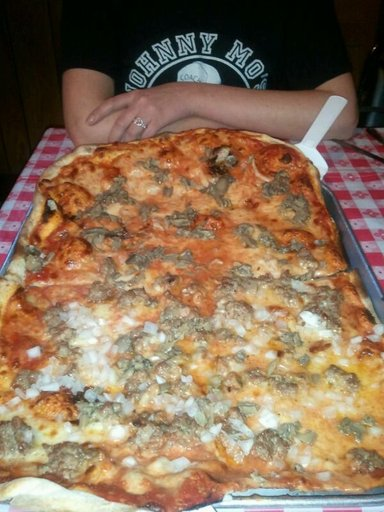

In [6]:
# Visualizing an image
import random
from PIL import Image

# Set seed
random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick a random image path
random_image_path = random.choice(image_path_list)



# Get image class from path name (image class is name of parent folder.)
image_class = random_image_path.parent.stem

# Open image.
img = Image.open(random_image_path)

# Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

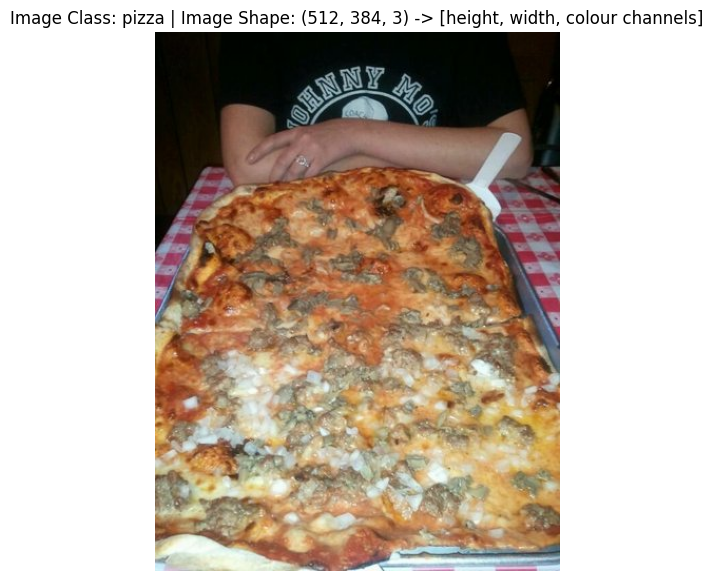

In [7]:
# Try to visualise an image with matplotlib
import matplotlib.pyplot as plt
import numpy as np
img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height, width, colour channels]")
plt.axis(False)

In [8]:
# Transforming data
# Before we can use our image data with PyTorch, we have to turn our target data into tensors.
# Turn it into torch.utils.data.Dataset
# Turn it into torch.utils.data.DataLoader

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Perform random horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    # Make the image into a tensor
    transforms.ToTensor()
])

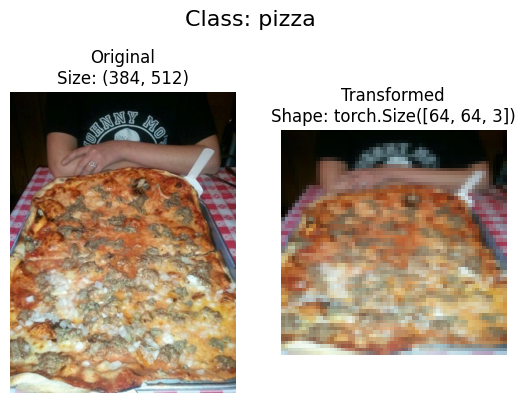

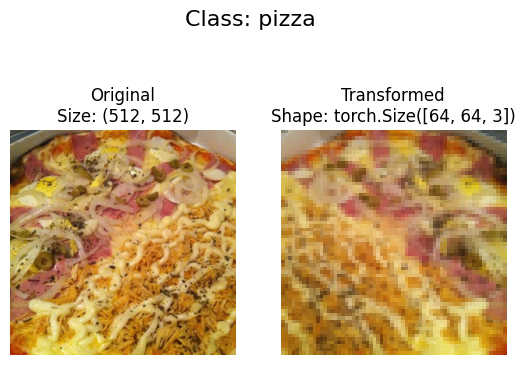

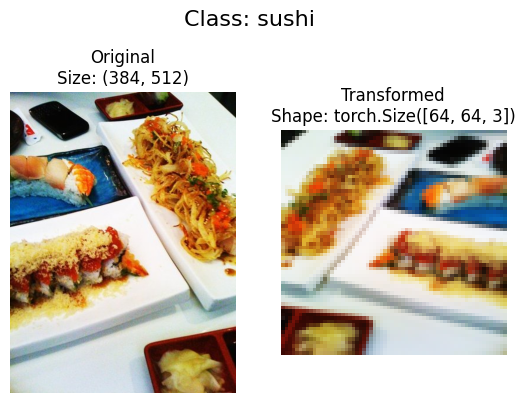

In [9]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them, and plots the original vs transformed version.
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

In [10]:
# Option 1 : Loading image data using ImageFolder

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
class_names = train_data.classes

In [12]:
# get class names as dict

class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:
# Check lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [14]:
# Turn Loaded Images into DataLoaders

# A DataLoader is going to help us turn our datasets into iterables and we can customise the batch_size.

from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e679b828490>,
 <torch.utils.data.dataloader.DataLoader at 0x7e679b84b970>)

In [15]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [16]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like.
print(f"Image shape: {img.shape} --> [batch_size, colour channels, height, width]")
print(f"Label Shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) --> [batch_size, colour channels, height, width]
Label Shape: torch.Size([1])


In [17]:
# Option 2 of loading data : Loading image data with a custom dataset.
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List

In [18]:
# instance
target_directory = train_dir
print(f"Target Dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [19]:
def find_classes(directory):
  # 1. Get the class nams by scanning the target directory
  classes = sorted([entry.name for entry in list(os.scandir(directory))])
  # 2. Raise an error if class names could not be found.
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")

  # 3. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [21]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e679b828490>,
 <torch.utils.data.dataloader.DataLoader at 0x7e679b84b970>)

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])